# Защита данных

Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию клиентов страховой компании.

## 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('/datasets/insurance.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde8718e090>,
      dtype=object)

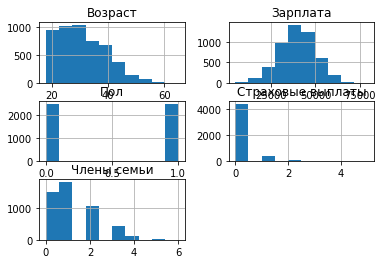

In [3]:
data.hist()

In [4]:
data.duplicated().sum()

153

Проблем с даными не наблюдается, помимо небольшого количества дубликатов.

In [5]:
data = data.drop_duplicates()

**Примечание:** думаю, что это необязательно дубликаты, могли попасться клиенты с одинаковыми параметрами.

## 2. Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Обоснование:**  
Пусть $a'$ - предсказания по изменённым признакам

$$
a = X(X^T X)^{-1} X^T y
$$

$$
a' = XP((XP)^T XP)^{-1} (XP)^T y
$$

Нужно показать, что $a = a'$

$$
a' = XP ((XP)^T XP)^{-1} (XP)^T y
$$

$$
a' = XP P^{-1} (P^T X^T X)^{-1} P^T X^T y
$$

$$
a' = X (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

$$
a' = X (X^T X)^{-1} X^T = a
$$

## 3. Алгоритм преобразования

**Алгоритм**

1. Сгенерировать обратимую матрицу
2. Матрицу признаков умножить на сгенерированную матрицу
3. Построить модель линейной регрессии для новых признаков

**Обоснование**

Как было показано выше, при умножении признаков на обратимую матрицу наши предсказания не изменятся. К исходным признакам можно будет вернуться умножением новых признаков на обратную матрицу.

## 4. Проверка алгоритма

In [6]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [7]:
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

Напишем функцию, которая генерирует обратимую матрицу. Чтобы матрица была обратимой должно выполняться два условия: она должна быть квадратной и иметь ненулевой определитель.

In [8]:
def invertible_matrix(size):
    matrix = np.random.normal(0, 10, (size, size))
    det = np.linalg.det(matrix) == 0
    while det != 0:
        matrix = np.random.normal(0, 10, (size, size))
        det = np.linalg.det(matrix) != 0
    return matrix

In [9]:
P = invertible_matrix(features.shape[1])

Обучим модель на исходных данных и на изменённых и сверим получившуюся метрику R2

In [10]:
model = LinearRegression()

model.fit(features, target)
predictions = model.predict(features)
print(r2_score(target, predictions))

0.4302010044852068


In [11]:
new_features = features.dot(P)

model.fit(new_features, target)
predictions = model.predict(new_features)
print(r2_score(target, predictions))

0.4302010044852108


Как и ожидалось качество модели не изменилось